In [2]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict

In [3]:
def regressionMetrics(y, yhat):
    res = {
        'MSE': metrics.mean_squared_error(y, yhat),
        'RMSE': np.sqrt(metrics.mean_squared_error(y, yhat)),
        'MAE': metrics.mean_absolute_error(y, yhat),
        'R2': metrics.r2_score(y, yhat)
    }

    # Check if all values are > -1 to safely apply log
    if np.all(y > -1) and np.all(yhat > -1):
        rmsle = np.sqrt(metrics.mean_squared_log_error(y, yhat))
        res['RMSLE'] = rmsle
    else:
        res['RMSLE'] = 'Not applicable (values ≤ -1)'

    return res

# load the df for test

In [785]:
df = pd.read_pickle('df_with_ev_ind.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075 entries, 9 to 2083
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2075 non-null   datetime64[ns]
 1   SPY_return                     2075 non-null   float64       
 2   SPY_Volume                     2075 non-null   float64       
 3   AAPL                           2075 non-null   float64       
 4   MSFT                           2075 non-null   float64       
 5   GOOG                           2075 non-null   float64       
 6   GLD                            2075 non-null   float64       
 7   SLV                            2075 non-null   float64       
 8   ^TNX                           2075 non-null   float64       
 9   DX-Y.NYB                       2075 non-null   float64       
 10  JPY=X                          2075 non-null   float64       
 11  EUR=X                 

# Add PE ratio

In [800]:
pe = pd.read_csv('pe-ratio.csv')
pe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        332 non-null    object 
 1   shiler pe   332 non-null    object 
 2   PE          341 non-null    object 
 3   Unnamed: 3  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 10.8+ KB


In [803]:
pe['date'] = pd.to_datetime(pe['date'])
pe.info()
pe['month'] = pe['date'].dt.month
pe['year'] = pe['date'].dt.year
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        332 non-null    datetime64[ns]
 1   shiler pe   332 non-null    object        
 2   PE          341 non-null    object        
 3   Unnamed: 3  0 non-null      float64       
 4   month       332 non-null    float64       
 5   year        332 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 16.1+ KB


In [805]:
df = pd.merge(df,pe[['month','year','PE','shiler pe']],how='left',on=['month','year'])
df.drop(['year', 'month'], axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 97 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2087 non-null   datetime64[ns]
 1   SPY_return                     2087 non-null   float64       
 2   SPY_Volume                     2087 non-null   float64       
 3   AAPL                           2087 non-null   float64       
 4   MSFT                           2087 non-null   float64       
 5   GOOG                           2087 non-null   float64       
 6   GLD                            2087 non-null   float64       
 7   SLV                            2087 non-null   float64       
 8   ^TNX                           2087 non-null   float64       
 9   DX-Y.NYB                       2087 non-null   float64       
 10  JPY=X                          2087 non-null   float64       
 11  EUR=X            

In [806]:
df['PE'].head()

0      23.59
1      23.59
2      23.59
3      23.59
4      23.59
Name: PE, dtype: object

In [786]:
lst =['Actual_GDP','Actual_CPI','Actual_PPI','Actual_unemployment rate','Actual_core_PCE','Actual_FOMC']
for col in lst:
    df[col] = df[col] *100

df['Actual_GDP'].head(20)

9    -500.0
10   -500.0
11   -500.0
12   -500.0
13   -500.0
14   -500.0
15      1.9
16   -500.0
17   -500.0
18   -500.0
19   -500.0
20   -500.0
21   -500.0
22   -500.0
23   -500.0
24   -500.0
25   -500.0
26   -500.0
27   -500.0
28   -500.0
Name: Actual_GDP, dtype: float64

In [519]:
df['day'].head(10)

9     19
10    20
11    23
12    24
13    25
14    26
15    27
16    30
17    31
18     1
Name: day, dtype: int32

In [787]:
df.reset_index(drop=True, inplace=True)
df.head()

,ds,SPY_return,SPY_Volume,AAPL,MSFT,GOOG,GLD,SLV,^TNX,DX-Y.NYB,...,March,April,May,June,July,August,September,October,November,December
0,2017-01-19,-0.370443,21.563768,-0.175019,-0.320008,-0.483210,-0.087060,-0.432364,2.930104,0.217974,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-20,0.367412,93.921224,0.183699,0.706284,0.354649,0.243972,0.434241,0.325331,-0.405342,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-23,-0.260222,-41.888663,0.066658,0.350635,1.775112,0.643197,0.617668,-2.594240,-0.575734,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-24,0.641182,27.302509,-0.091620,0.889458,0.556575,-0.449093,-0.429721,2.829789,0.189691,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-25,0.865543,-11.634729,1.592078,0.251904,1.432266,-0.824149,-0.739821,2.104413,-0.318884,...,0,0,0,0,0,0,0,0,0,0


## This df is to add feture to the model df

In [788]:
df_add = pd.read_pickle('combined_cleaned_add.pkl')
df_add.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Close            2084 non-null   float64
 1   SPY_Volume           2084 non-null   int64  
 2   AAPL                 2084 non-null   float64
 3   MSFT                 2084 non-null   float64
 4   GOOG                 2084 non-null   float64
 5   GLD                  2084 non-null   float64
 6   SLV                  2084 non-null   float64
 7   ^TNX                 2084 non-null   float64
 8   DX-Y.NYB             2084 non-null   float64
 9   JPY=X                2084 non-null   float64
 10  EUR=X                2084 non-null   float64
 11  USO                  2084 non-null   float64
 12  UNG                  2084 non-null   float64
 13  BTC-USD              2084 non-null   float64
 14  CPER                 2084 non-null   float64
 15  ^VIX                

# Add some more fetures

In [789]:
#df_add['SPY_Volume'].head(10)
df_add['vol_mean_30'] = df_add['SPY_Volume'].rolling(30).mean()
#df_add['vol_mean_30'].tail(30) 
df_add['vol_above_mean'] = (df_add['SPY_Volume'] > df_add['vol_mean_30']).astype(int)
df_add['vol_above_mean'].tail(25)

Date
2025-03-13    0
2025-03-14    0
2025-03-17    0
2025-03-18    0
2025-03-19    0
2025-03-20    0
2025-03-21    1
2025-03-24    0
2025-03-25    0
2025-03-26    0
2025-03-27    0
2025-03-28    0
2025-03-31    1
2025-04-01    0
2025-04-02    0
2025-04-03    1
2025-04-04    1
2025-04-07    1
2025-04-08    1
2025-04-09    1
2025-04-10    1
2025-04-11    0
2025-04-14    0
2025-04-15    0
2025-04-16    0
Name: vol_above_mean, dtype: int64

## Add DXY absolute value:

# Add volum above mean & absolute value of vix
Helps the model 

In [790]:
to_add = df_add[['vol_above_mean','^VIX']].copy()
#to_add = df_add[['vol_above_mean','^VIX','DX-Y.NYB']].copy()
to_add.reset_index(inplace=True)
to_add.rename(columns={'Date':'ds','^VIX': 'abs_vix'}, inplace=True)
#to_add.rename(columns={'Date':'ds','^VIX': 'abs_vix','DX-Y.NYB': 'DXY'}, inplace=True)


In [791]:
to_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              2084 non-null   datetime64[ns]
 1   vol_above_mean  2084 non-null   int64         
 2   abs_vix         2084 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 49.0 KB


In [792]:
df = df.merge(to_add, on='ds', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 95 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2075 non-null   datetime64[ns]
 1   SPY_return                     2075 non-null   float64       
 2   SPY_Volume                     2075 non-null   float64       
 3   AAPL                           2075 non-null   float64       
 4   MSFT                           2075 non-null   float64       
 5   GOOG                           2075 non-null   float64       
 6   GLD                            2075 non-null   float64       
 7   SLV                            2075 non-null   float64       
 8   ^TNX                           2075 non-null   float64       
 9   DX-Y.NYB                       2075 non-null   float64       
 10  JPY=X                          2075 non-null   float64       
 11  EUR=X            

In [793]:
y = df['SPY_return']
x = df.drop(['SPY_return', 'ds','^VIX_rank'], axis=1)
#'^VIX_rank'
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 92 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SPY_Volume                     2075 non-null   float64
 1   AAPL                           2075 non-null   float64
 2   MSFT                           2075 non-null   float64
 3   GOOG                           2075 non-null   float64
 4   GLD                            2075 non-null   float64
 5   SLV                            2075 non-null   float64
 6   ^TNX                           2075 non-null   float64
 7   DX-Y.NYB                       2075 non-null   float64
 8   JPY=X                          2075 non-null   float64
 9   EUR=X                          2075 non-null   float64
 10  USO                            2075 non-null   float64
 11  UNG                            2075 non-null   float64
 12  BTC-USD                        2075 non-null   f

In [794]:
split = int(len(y)*0.9)
x_train = x.iloc[:split]
x_test = x.iloc[split:]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [ ]:
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit

# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train)
results = []


tscv = TimeSeriesSplit(n_splits=5)

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
    model.fit(x_train, y_train, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight with added slope w={best_w:.2f} with MAE={best_mae:.4f}")


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.0, MAE=0.2694


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.1, MAE=0.2687


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.2, MAE=0.2691


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.3, MAE=0.2667


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.4, MAE=0.2636


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.5, MAE=0.2670


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.6, MAE=0.2673


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.7, MAE=0.2713


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.8, MAE=0.2635


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.9, MAE=0.2678


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.0, MAE=0.2654


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.1, MAE=0.2703


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.2, MAE=0.2635


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.3, MAE=0.2655


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.4, MAE=0.2698


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.5, MAE=0.2729


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.6, MAE=0.2678


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.7, MAE=0.2716


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.8, MAE=0.2730


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.9, MAE=0.2742


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:45:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "cv", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=3.0, MAE=0.2761

✅ Best weight with added slope w=1.80 with MAE=0.2635


In [730]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train)
weights = np.linspace(1, 1.8, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
xg_ind.fit(x_train, y_train,sample_weight=weights)
predicted_xg_ind2 = xg_ind.predict(x_test)
regressionMetrics(y_test,predicted_xg_ind2)

{'MSE': 0.18639398567859058,
 'RMSE': np.float64(0.4317336976407917),
 'MAE': 0.26345546164690903,
 'R2': 0.8939526288502173,
 'RMSLE': 'Not applicable (values ≤ -1)'}

Text(0, 0.5, 'Predictions')

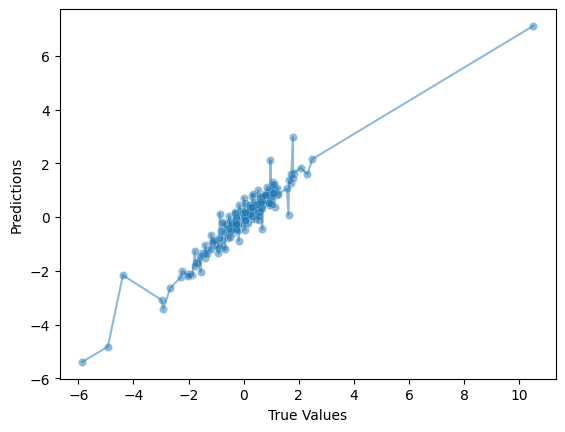

In [732]:
sns.scatterplot(x=y_test, y=predicted_xg_ind2, alpha=0.5)
sns.lineplot(x=y_test, y=predicted_xg_ind2, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')

## Best resaults so far

{'MSE': 0.1739106651896815,
 'RMSE': np.float64(0.41702597663656576),
 'MAE': 0.25650022213579016,
 'R2': 0.9010549166823064,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# Feture selection

In [733]:
model = xgb.XGBRegressor(n_estimators=200, random_state=42)
model.fit(x, y)

# Create DataFrame of importance
feature_importance = pd.DataFrame({
    'feature': x.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top N
selected_features = feature_importance[feature_importance['importance'] > 0.00]['feature'].tolist()

In [262]:
feature_importance.head(20)

,feature,importance
17,IWM,0.565797
2,MSFT,0.183204
64,stdev,0.026197
14,^VIX,0.025132
15,^GDAXI,0.024030
3,GOOG,0.020973
1,AAPL,0.018254
54,EMA_20,0.016512
35,Actual_FOMC,0.009062
24,high-low,0.007858


In [21]:
import seaborn as sns
#import matplotlib.pyplot as plt


Text(0.5, 0, 'Importance')

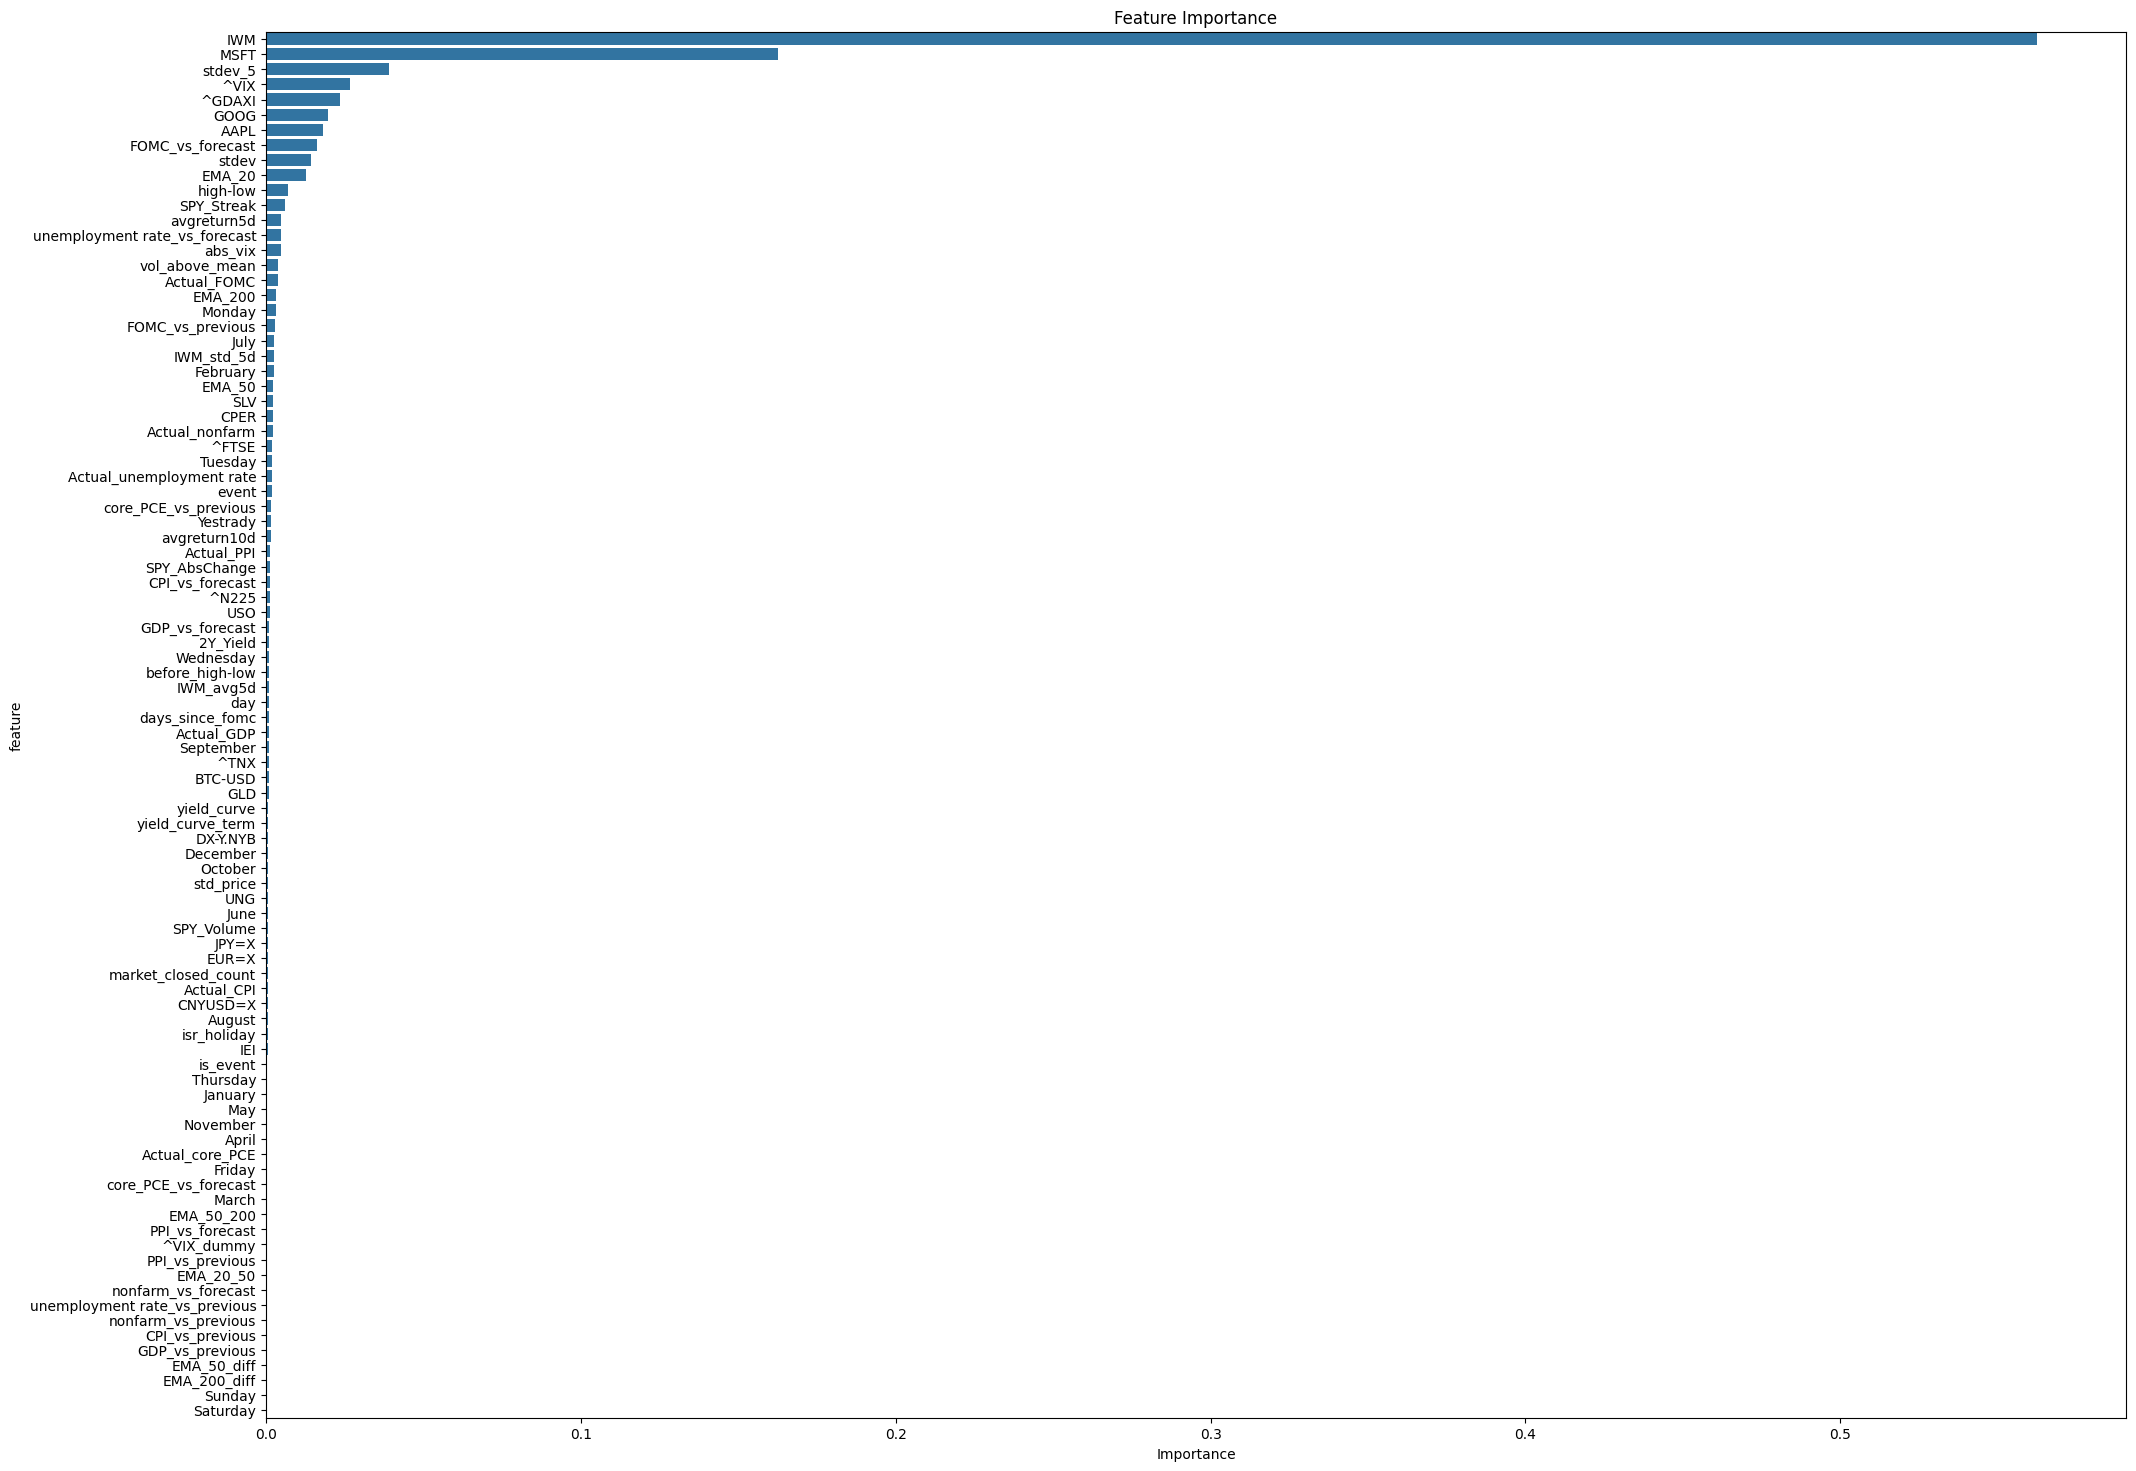

In [719]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 18))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance')

In [373]:
print(len(selected_features))

81


In [734]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, x, y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]
important_features = x.columns[sorted_idx[:38]] # 38 is the number that yields the best resaults 
print(important_features)

Index(['IWM', 'MSFT', '^VIX', 'AAPL', 'GOOG', 'stdev_5', 'EMA_20', 'abs_vix',
       'avgreturn5d', 'high-low', '^GDAXI', '^FTSE', 'stdev', 'std_price',
       'IWM_avg5d', 'IWM_std_5d', 'SPY_Volume', 'SLV', '^N225', 'EMA_200',
       'USO', 'DX-Y.NYB', 'CPER', 'before_high-low', 'SPY_Streak',
       'avgreturn10d', 'EMA_50', 'CNYUSD=X', 'GLD', 'EUR=X', '^TNX',
       'Yestrady', 'yield_curve', 'day', 'JPY=X', 'SPY_AbsChange', 'BTC-USD',
       'UNG'],
      dtype='object')


In [776]:
important_features = x.columns[sorted_idx[:55]] # 38 is the number that yields the best resaults 
print(important_features)

Index(['IWM', 'MSFT', '^VIX', 'AAPL', 'GOOG', 'stdev_5', 'EMA_20', 'abs_vix',
       'avgreturn5d', 'high-low', '^GDAXI', '^FTSE', 'stdev', 'std_price',
       'IWM_avg5d', 'IWM_std_5d', 'SPY_Volume', 'SLV', '^N225', 'EMA_200',
       'USO', 'DX-Y.NYB', 'CPER', 'before_high-low', 'SPY_Streak',
       'avgreturn10d', 'EMA_50', 'CNYUSD=X', 'GLD', 'EUR=X', '^TNX',
       'Yestrady', 'yield_curve', 'day', 'JPY=X', 'SPY_AbsChange', 'BTC-USD',
       'UNG', '2Y_Yield', 'days_since_fomc', 'IEI', 'Monday', 'Thursday',
       'yield_curve_term', 'Actual_FOMC', 'February', 'Wednesday', 'July',
       'Tuesday', 'vol_above_mean', 'market_closed_count', 'EMA_50_200',
       'Actual_GDP', 'Friday', 'November'],
      dtype='object')


In [777]:
y_s = df['SPY_return']
x_s = df[important_features]
x_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 55 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IWM                  2075 non-null   float64
 1   MSFT                 2075 non-null   float64
 2   ^VIX                 2075 non-null   float64
 3   AAPL                 2075 non-null   float64
 4   GOOG                 2075 non-null   float64
 5   stdev_5              2075 non-null   float64
 6   EMA_20               2075 non-null   float64
 7   abs_vix              2075 non-null   float64
 8   avgreturn5d          2075 non-null   float64
 9   high-low             2075 non-null   float64
 10  ^GDAXI               2075 non-null   float64
 11  ^FTSE                2075 non-null   float64
 12  stdev                2075 non-null   float64
 13  std_price            2075 non-null   float64
 14  IWM_avg5d            2075 non-null   float64
 15  IWM_std_5d           2075 non-null   f

In [778]:
split = int(len(y)*0.9)
x_train = x_s.iloc[:split]
x_test = x_s.iloc[split:]
y_train = y_s.iloc[:split]
y_test = y_s.iloc[split:]

In [781]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train)
weights = np.linspace(1, 2.1, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
xg_ind.fit(x_train, y_train,sample_weight=weights)
predicted_xg_ind2 = xg_ind.predict(x_test)
regressionMetrics(y_test,predicted_xg_ind2)

{'MSE': 0.16287839115441097,
 'RMSE': np.float64(0.40358195097701155),
 'MAE': 0.26141002884289716,
 'R2': 0.9073316387535391,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# Best resaults from permutation_importance using 38 top fetures
{'MSE': 0.16332414855521937,
 'RMSE': np.float64(0.40413382505702167),
 'MAE': 0.2547603217483426,
 'R2': 0.9070780307293864,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## Added iwm avg & std using top 45 :
{'MSE': 0.15929380586598665,
 'RMSE': np.float64(0.39911628113368997),
 'MAE': 0.2546392991474355,
 'R2': 0.9102085438157346,
 'RMSLE': 'Not applicable (values ≤ -1)'}

## Added iwm avg & std using top 60 ( with longer df):
 {'MSE': 0.16119299764366776,
 'RMSE': np.float64(0.4014884775976364),
 'MAE': 0.2582829648071678,
 'R2': 0.9082905320114445,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## Added cny/usd using top 55
 {'MSE': 0.15946313641758256,
 'RMSE': np.float64(0.39932835664097605),
 'MAE': 0.2541777543995169,
 'R2': 0.9092747206900562,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [780]:
from sklearn.metrics import mean_absolute_error, make_scorer

# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train)
results = []

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
    model.fit(x_train, y_train, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight with added slope w={best_w:.2f} with MAE={best_mae:.4f}")


w=1.0, MAE=0.2677
w=1.1, MAE=0.2686
w=1.2, MAE=0.2701
w=1.3, MAE=0.2679
w=1.4, MAE=0.2636
w=1.5, MAE=0.2630
w=1.6, MAE=0.2639
w=1.7, MAE=0.2654
w=1.8, MAE=0.2718
w=1.9, MAE=0.2670
w=2.0, MAE=0.2683
w=2.1, MAE=0.2614
w=2.2, MAE=0.2654
w=2.3, MAE=0.2626
w=2.4, MAE=0.2679
w=2.5, MAE=0.2682
w=2.6, MAE=0.2621
w=2.7, MAE=0.2670
w=2.8, MAE=0.2649
w=2.9, MAE=0.2682
w=3.0, MAE=0.2708

✅ Best weight with added slope w=2.10 with MAE=0.2614


In [782]:
check_df = pd.concat([y_test, pd.Series(predicted_xg_ind2, index=y_test.index)], axis=1)
check_df.columns = ['Actual', 'Predicted']  # Optional: name the columns
check_df.tail(20)

,Actual,Predicted
2055,-0.289173,-0.526969
2056,0.032986,0.071711
2057,1.790850,1.430297
2058,0.240385,0.419508
2059,-1.193827,-1.228583
2060,-0.265571,-0.265155
2061,-2.013833,-1.933583
2062,0.671281,-0.567900
2063,0.282443,0.479379
2064,0.632841,0.523001


In [640]:
print(len(y_test))

208


In [783]:
check_df['price_actual'] = 300 * (1 + check_df['Actual'] / 100).cumprod()
check_df['price_predicted'] = 300 * (1 + check_df['Predicted'] / 100).cumprod()

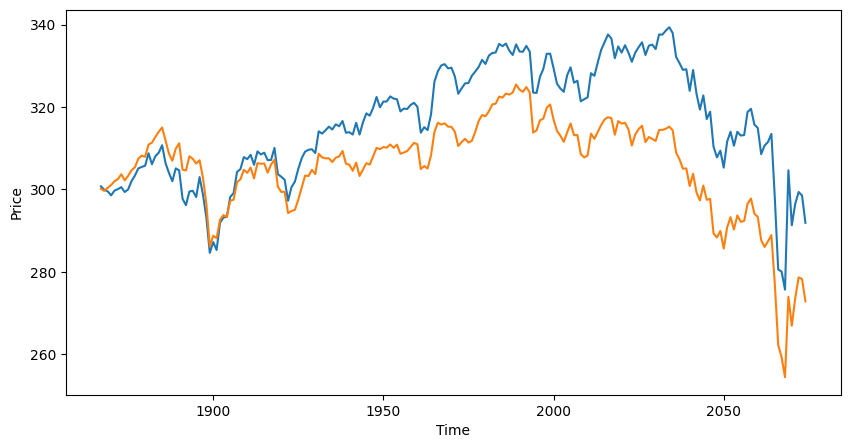

In [784]:
plt.figure(figsize=(10, 5))
plt.plot(check_df['price_actual'], label='Actual Price')
plt.plot(check_df['price_predicted'], label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# Grid search

In [ ]:
xgb_param_grid = {
    'n_estimators': [200,300],
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.6,0.8,1],
    'gamma':[0, 0.1],
    'reg_alpha':[0, 0.1],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# Define candidate weight scalings to search over
w_candidates = np.arange(1.0, 3.1, 0.2)  # Try from 1.0 to 3.0 in steps of 0.2

best_mae = float('inf')
best_xgb_model = None
best_w = None
best_params = None

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for w in w_candidates:
    print(f"\n🔍 Testing weight slope: {w:.2f}")
    
    # Create weights linearly increasing from 1 to w
    num_samples = len(y_train_ind2)
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Grid search
    xgb_grid = GridSearchCV(
        XGBRegressor(n_jobs=-1, random_state=42, verbosity=0),
        param_grid=xgb_param_grid,
        cv=tscv,
        scoring=mae_scorer,
        verbose=0
    )

    xgb_grid.fit(x_train_ind2, y_train_ind2, sample_weight=weights)
    model = xgb_grid.best_estimator_

    # Evaluate on test set
    preds = model.predict(x_test_ind2)
    mae = mean_absolute_error(y_test_ind2, preds)
    print(f"→ MAE: {mae:.4f} | Best Params: {xgb_grid.best_params_}")

    if mae < best_mae:
        best_mae = mae
        best_xgb_model = model
        best_w = w
        best_params = xgb_grid.best_params_

# 🎉 Final result
print(f"\n✅ Best XGBoost Model")
print(f"MAE: {best_mae:.4f}")
print(f"Weight slope (w): {best_w}")
print(f"Hyperparameters: {best_params}")
